Data Pre-Processing

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
data = pd.read_csv("credit_risk_dataset.csv")
# Print shape of dataset
print(data.shape)

(32581, 12)


# Data Cleaning

Handling Missing values
Handling Missing values
Handling Duplicates
Check data type
Understand the dataset

In [50]:
##these are the features with nan value
features_with_na=[features for features in data.columns if data[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(data[feature].isnull().mean()*100,5), '% missing values')

person_emp_length 2.747 % missing values
loan_int_rate 9.56386 % missing values


In [8]:
from sklearn.impute import KNNImputer  
def impute_missing_val(X, neighbors=5):     
    data = X.copy()     
    imputer = KNNImputer(n_neighbors=neighbors)     
    data['person_emp_length'] = imputer.fit_transform(data[['person_emp_length']])     
    data['loan_int_rate'] = imputer.fit_transform(data[['loan_int_rate']])     
    return data


In [51]:
from sklearn.impute import KNNImputer

def impute_missing_val(X, neighbors=5):
    """
    Impute missing values in 'person_emp_length' and 'loan_int_rate' using KNN.

    Parameters:
    X (pd.DataFrame): Input DataFrame with missing values.
    neighbors (int): Number of neighbors to use for imputation.

    Returns:
    pd.DataFrame: DataFrame with imputed values.
    """
    data = X.copy()
    imputer = KNNImputer(n_neighbors=neighbors)
    columns_to_impute = ['person_emp_length', 'loan_int_rate']
    
    data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])
    
    return data


In [54]:
cleaned_data = impute_missing_val(data)

In [55]:
cleaned_data.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

Illogical Outliers. 
For the person age and person employment length, there are entries that have more than 100 years. 
In a real world case, this is certainly not realistic. Our decision for this is to drop the row altogether.
 However, for the outlier in the income, we can still keep it since it is a realistic case in the real world. Here is how I dropped the outliers:

In [31]:
def drop_outliers(X):     
    data = X.copy()     
    data = data.drop(data[data['person_age'] > 100].index)     
    data = data.drop(data[data['person_emp_length'] > 100].index)     
    return data

In [56]:
cleaned_data = drop_outliers(cleaned_data)

Transform Categorical Feature

For the person home ownership and loan intent, we can use the one hot encoding. 
Why? because the category is not that many and they do not have any logical order

For the loan grade we can use the ordinal encoder, since each of the category carries some weight and values that have logical order.
Lastly, for the person_default_on_file just simply 1 for yes and 0 for no.

In [57]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
levar = {}
# Iterate through all categorical columns
def encode_cat(data):
  for col in data.select_dtypes(include=['object']).columns:
      encoder = preprocessing.LabelEncoder()
      data[col] = encoder.fit_transform(data[col])  # Perform label encoding
      levar[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

In [58]:
from sklearn import preprocessing

levar = {}

def encode_cat(data):
    """
    Label-encode all categorical (object) columns in the DataFrame.
    
    Parameters:
    data (pd.DataFrame): The input DataFrame with categorical columns.
    
    Returns:
    pd.DataFrame: The DataFrame with encoded categorical columns.
    """
    data = data.copy()  # Avoid changing the original
    for col in data.select_dtypes(include=['object']).columns:
        encoder = preprocessing.LabelEncoder()
        data[col] = encoder.fit_transform(data[col].astype(str))  # Convert to string in case of NaNs
        levar[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    return data


In [68]:
cleaned_data=encode_cat(cleaned_data)

Feature Transformation

Some of the feature here have a very heavy tail distributions:
 person age, person employment length, loan amount, person income, loan percent income, loan amount, person credit history, and interest rate (basically all the numerical features). 
 
 Thus we need to transform it first using the logarithm function, before normalize it using the standarization techniques. Here is how I standardized all the numerical features:

In [60]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def log_transform(df, columns):
    df_log = df.copy()
    for col in columns:
        df_log[col] = np.log1p(df[col]) 
    return df_log

In [66]:
from sklearn.preprocessing import StandardScaler


def standardize_data(X):
    data = X.copy()
    num_features = data.select_dtypes(include=['int64', 'float64']).columns
    num_features = num_features.drop('loan_status')
    scaler = StandardScaler()
    data = log_transform(data, num_features)
    data[num_features] = scaler.fit_transform(data[num_features])
    return data

In [ ]:
standardize_data(cleaned_data)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,-1.296120,-3.104317,OWN,0.382316,EDUCATION,B,-2.856984,0.143909,0,-0.659102,N,-1.285250
2,-0.419197,-3.104317,MORTGAGE,-1.022955,MEDICAL,C,-0.462129,0.638099,1,3.389871,N,-0.735709
3,-0.839368,0.291585,RENT,0.149103,MEDICAL,C,2.138653,1.220986,1,3.096151,N,-1.285250
4,-0.625080,-0.036798,RENT,0.900960,MEDICAL,C,2.138653,0.994812,1,3.243959,Y,-0.309452
5,-1.296120,-3.049902,OWN,-0.504311,VENTURE,A,-1.569990,-1.338840,1,0.795772,N,-1.285250
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,3.792592,-0.082907,MORTGAGE,-1.022955,PERSONAL,C,-0.387497,0.714859,0,-0.556106,N,3.175871
32577,3.513800,1.362306,MORTGAGE,0.149103,PERSONAL,A,1.174486,-1.182674,0,-0.153196,N,2.338700
32578,4.470868,0.554530,RENT,-0.136328,HOMEIMPROVEMENT,B,2.138653,0.097789,1,2.563163,N,3.048475
32579,3.701297,1.756936,MORTGAGE,0.382316,PERSONAL,B,0.947839,0.246371,0,-0.659102,N,2.911971


In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def log_transform(df, columns):
    df_log = df.copy()
    for col in columns:
        df_log[col] = np.log1p(df[col]) 
    return df_log

In [22]:

data.isnull().sum()



person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [38]:
train_cpy = impute_missing_val(data)
train_cpy = drop_outliers(data)
train_cpy = standardize_data(data)
encode_cat(data)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,3,123.0,4,3,35000,16.02,1,0.59,1,3
1,21,9600,2,5.0,1,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,2,5500,12.87,1,0.57,0,3
3,23,65500,3,4.0,3,2,35000,15.23,1,0.53,0,2
4,24,54400,3,8.0,3,2,35000,14.27,1,0.55,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,0,1.0,4,2,5800,13.16,0,0.11,0,30
32577,54,120000,0,4.0,4,0,17625,7.49,0,0.15,0,19
32578,65,76000,3,3.0,2,1,35000,10.99,1,0.46,0,28
32579,56,150000,0,5.0,4,1,15000,11.48,0,0.10,0,26


In [69]:
y=cleaned_data['loan_status']
X = cleaned_data.drop('loan_status', axis=1)


In [64]:
cleaned_data.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [70]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

In [71]:
from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((28204, 11), (7051, 11))

In [72]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [73]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [74]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()

}

In [75]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report

In [76]:
base_model_report =evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9489
- F1 score: 0.9492
- Precision: 0.9614
- Recall: 0.9373
- Roc Auc Score: 0.9492


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9169
- F1 score: 0.9186
- Precision: 0.9153
- Recall: 0.9219
- Roc Auc Score: 0.9168


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9218
- F1 score: 0.9220
- Precision: 0.9424
- Recall: 0.9024
- Roc Auc Score: 0.9223
----------------------------------
Model performance for Test set
- Accuracy: 0.9196
- F1 score: 0.9191
- Precision: 0.9413
- Recall: 0.8980
- Roc Auc Score: 0.9200


Logistic Regression
Model performance for Training 

In [77]:
base_model_report

,Model Name,Accuracy
5,XGBClassifier,0.970926
6,CatBoosting Classifier,0.970075
4,K-Neighbors Classifier,0.957736
0,Random Forest,0.948943
2,Gradient Boosting,0.919586
1,Decision Tree,0.916891
8,AdaBoost Classifier,0.878031
3,Logistic Regression,0.815062
7,Support Vector Classifier,0.782584


In [78]:
#Initialize few parameter for Hyperparamter tuning
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [79]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

In [80]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2, 
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
---------------- Best Params for XGBoost -------------------
{'min_child_weight': 1, 'max_depth': 5}
---------------- Best Params for RF -------------------
{'n_estimators': 100, 'max_features': 'log2', 'max_depth': None}
---------------- Best Params for KNN -------------------
{'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'auto'}


In [81]:
from sklearn.metrics import roc_auc_score,roc_curve
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost'],n_jobs=-1),
}
tuned_report =evaluate_models(X=X_res, y=y_res, models=best_models)

Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9514
- F1 score: 0.9516
- Precision: 0.9629
- Recall: 0.9406
- Roc Auc Score: 0.9515


KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9862
- F1 score: 0.9865
- Precision: 0.9834
- Recall: 0.9897
- Roc Auc Score: 0.9862


XGBClassifier
Model performance for Training set
- Accuracy: 0.9810
- F1 score: 0.9812
- Precision: 0.9918
- Recall: 0.9708
- Roc Auc Score: 0.9812
----------------------------------
Model performance for Test set
- Accuracy: 0.9660
- F1 score: 0.9661
- Precision: 0.9783
- Recall: 0.9543
- Roc Auc Score: 0.9662




In [82]:
tuned_report

,Model Name,Accuracy
1,KNeighborsClassifier,0.986243
2,XGBClassifier,0.965962
0,Random Forest Classifier,0.951354


In [83]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9862
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3464
           1       0.98      0.99      0.99      3587

    accuracy                           0.99      7051
   macro avg       0.99      0.99      0.99      7051
weighted avg       0.99      0.99      0.99      7051



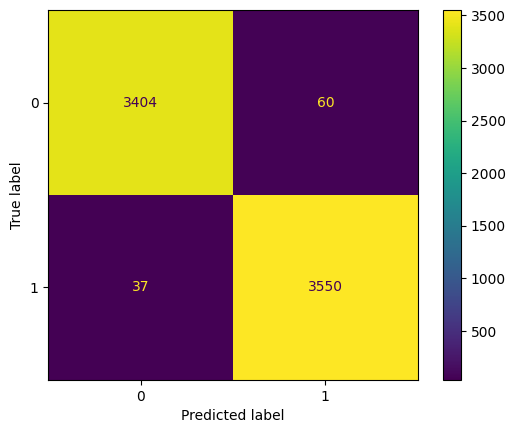

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)